# CxVISION - Processing  independent videos

This notebook will guide you in how to deploy the CxVision Model Package from AWS Marketplace to process independent videos. At the end of this execution, the architecture will look like this:

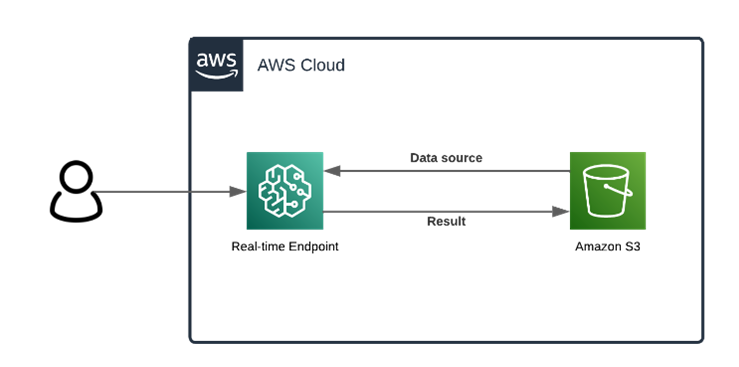

## Usage instructions

Run this Jupyter notebook one cell a time and press `Shift+Enter` to run each consecutive cell.

## Pre-requisites

1. This notebook renders correctly in Jupyter Notebook interface, so please open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
2. Ensure that IAM role used has `AmazonSageMakerFullAccess` policy.
3. To deploy this ML model successfully, ensure that:
   1. You are able to make AWS Marketplace subscriptions and our IAM role has the following permissions:
      - `aws-marketplace:ViewSubscriptions`
      - `aws-marketplace:Unsubscribe`
      - `aws-marketplace:Subscribe`
4. Create an Amazon S3 Bucket and upload the videos you want to process with the solution.
5. Create two Amazon SNS topics, for success and failed notifications.


## Contents

1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create the model](#2.-Create-the-model)
3. [Deploy the model](#3.-Deploy-the-model)
4. [Perform inferences](#5.-Perform-inferences)
5. [Visualize results](#6.-Visualize-results)
6. [Clean Up your environment](#7.-Clean-Up-your-environment)

### 1. Subscribe to the model package

1. Open the model package page ["Customer experience vision"]().
2. Click on the **Continue to subscribe** button.
3. On the **Subscribe to this software** page, review it and click on **"Accept Offer"**.
4. Click on **Continue to configuration button** and then select a **region**. The **Product ARN** will be displayed. **This is the model package ARN that you need to specify while creating a deployable model using Boto3.**


### 2. Create the model

Create the model using the ARN of the CXVision Model Package

In [ ]:
from sagemaker import ModelPackage

sagemaker_role = '<YourSageMakerRole>' # Replace with your IAM Role for Sage Maker
sagemaker_model_package_arn = '<ModelPackageARN>' # Replace this with your subcribed model package ARN

model = ModelPackage(role=sagemaker_role, 
                     model_package_arn=sagemaker_model_package_arn)

### 3. Deploy the model
The following cell deploys the created model on an asynchronous endpoint.

> Please, replace with your instance type. Supported instances types: ml.g4dn.xlarge, ml.g4dn.2xlarge, ml.g4dn.4xlarge, ml.g4dn.8xlarge, ml.g4dn.12xlarge

In [ ]:
import sagemaker
import uuid

instance_type='<InstanceType>' # Replace with your instance type. Supported instances types: ml.g4dn.xlarge, ml.g4dn.2xlarge, ml.g4dn.4xlarge, ml.g4dn.8xlarge, ml.g4dn.12xlarge
bucket = '<YourBucketName>'    # Replace with your bucket name.
output_key = '<OutputFolderKey>' # Replace with your bucket output folder.
success_topic_arn = '<YourSuccessTopicArn>' # Replace with your success SNS Topic ARN
error_topic_arn = '<YourEuccessTopicArn>'   # Replace with your error SNS Topic ARN

job_name='cxvision'
initial_instance_count=1  
endpoint_name = '{}-{}'.format(job_name,str(uuid.uuid4()))

predictor = model.deploy(
    initial_instance_count=initial_instance_count,
    instance_type=instance_type,
    endpoint_name=endpoint_name,
    async_inference_config=sagemaker.async_inference.AsyncInferenceConfig(
        output_path=f"s3://{bucket}/{output_key}",
        max_concurrent_invocations_per_instance=1,
        notification_config={
            'SuccessTopic': success_topic_arn,
            'ErrorTopic': error_topic_arn,
        }
    )
)

print('Endpoint name: {}'.format(endpoint_name))

### 4. Perform inferences
To invoke the endpoint, please ensure you have uploaded the videos you want to process to an Amazon S3 bucket.

### 4.1 Create the payload for the endpoint and upload it to Amazon S3

This payload contains some information that will be used for the model to process the files. This object has the following attributes:

* **blurring:** `True` if you want to apply blurring on the detected people. Otherwise, it's value must be `False`
* **detection_threshold**: Indicates the threshold to consider a detection as valid one. All the detections with the confidence equal or higher than the detection_threshold will be taken. `It must be a float value between 5 and 100.`
* **timezone:**  Defines the timezone for processing the videos.
* **s3_upload_path:** Amazon S3 folder where the solution will upload the results. 
* **areas:** Defines the areas and zones of the videos. Please, see how to define the areas in the [Define Areas Notebook](./DefineAreas.ipynb).
* **videos**: A list of videos to be processed. The `path` of each object need to be an Amazon S3 Path and the `area` must be one of the areas specified in the areas array.

Example:

```
{
    "blurring": False,
    "detection_threshold": 50,
    "timezone": "America/Caracas",
    "s3_upload_path": "cxvision/videos_out_local",
    "process_video_quantity": 0.02,
    "areas":[
        {
            "area": "restaurant",
            "dwell_zone": "[(200,500), (500,510), (490,710), (190,700)]",
            "service_zone": "[(540,580), (1000,645), (990,720), (530,655)]"
        }
    ],
    "videos": [
        {
          "path":"s3://cxvision/videos-in/maki_japan.mp4",
          "area":"restaurant"
        }
    ]
}
```

#### Create payload

In [ ]:
import json

#Update the object according to your videos
payload = {
    "blurring": False,
    "detection_threshold": 50,
    "timezone": "America/Caracas",
    "s3_upload_path": "cxvision/videos_out_local",
    "areas":[
        {
            "area": "your_zone",
            "dwell_zone": "your_dwell_zone",
            "service_zone": "your_service_zone"
        }
    ],
    "videos": [
        {
          "path":"your_s3_path",
          "area":"your_zone"
        }
    ]
}

payload = json.dumps(payload, indent=2, default=str)

#### Upload payload to Amazon S3 as a JSON file

In [ ]:
import boto3
from datetime import datetime

client = boto3.client('s3')
bucket = "cxvision"
prefix = "input_data_async/"
new_file = datetime.now().strftime("%d-%m-%Y-%H:%M:%S") + '.json'

response = client.put_object(
    Bucket=bucket, 
    Key=prefix + new_file,
    Body=payload
)

response

### 4.2 Invoke endpoint
The following code will invoke the asynchronous endpoint to process all the videos in the Amazon S3 path, and then it will upload the results to the same bucket.

In [ ]:
import boto3
runtime= boto3.client('runtime.sagemaker')

sagemaker_client = boto3.client('runtime.sagemaker') 
input_s3_location = 's3://' + bucket + '/' + prefix + new_file

response = sagemaker_client.invoke_endpoint_async(
    EndpointName=endpoint_name, InputLocation=input_s3_location
)
output_location = response["OutputLocation"]
print(f"OutputLocation: {output_location}")

### 5. Visualize results

The results of each video will be uploaded to the path specified in the response of the previous invocations. The results consist of two files:

1. Processed video with the detections of people, times in each zone and count of these.
2. A text file in the form of logs with the metrics generated during each frame processed in the video. This txt file contains the following structure:

```
Frame 59 - 2022-12-01 13:07:02.127757. Metric_data: total_detections * 6 * video * maki_japan.mp4 * dwell_detections * 3 * dwell_ids * 1,2,4 * dwell_time * 1,1,1 * service_detections * 3 * service_ids * 3,5,6 * service_time * 1,1,1
```

### 5. Clean Up your environment:

#### 1. Delete the model

In [ ]:
predictor.delete_endpoint(delete_endpoint_config=True)
model.delete_model()

#### 2. Unsubscribe (optional)

1. Ensure that you do not have a [running model](https://console.aws.amazon.com/sagemaker/home#/models).
2. Go to __Machine Learning__ tab on [Your Software Subscriptions](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust) page.
2. Locate the listing that you want to cancel the subscription for and then choose __Cancel Subscription__.